In [5]:
#ip: 168.188.128.36
#port: 20370:22, 20371:8888
#putty의 설정 source port:8888 Destination : localhost:8888 저장
#jupyter notebook --no-browser --allow-root
#나오는 토큰 설정의 구성된 서버에 입력
import sys
import torch

In [6]:
print("python version:",sys.version)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

python version: 3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]
Torch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


In [7]:
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from shap_e.util.notebooks import decode_latent_mesh

In [4]:
if torch.cuda.is_available():
    print("GPU 사용 가능")
    print("GPU 이름:", torch.cuda.get_device_name(0))
    print("현재 디바이스:", torch.cuda.current_device())
else:
    print("GPU 사용 불가")


GPU 사용 가능
GPU 이름: Tesla P100-PCIE-16GB
현재 디바이스: 0


In [8]:
!nvidia-smi
!rm -rf /root/hongdyu/hongdyu/shap_e_model_cache/text_cond.pt

Sat May 17 11:47:53 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:04:00.0 Off |                    0 |
| N/A   47C    P0              46W / 250W |  15620MiB / 16384MiB |     81%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
#nvidia-smi gpu 상태 확인
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [10]:
xm = load_model('transmitter', device=device)
shap_e_model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

In [9]:
# need_pytorch3d = False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d = True
#
# if need_pytorch3d:
#     # PyTorch 2.0.1 + cu117 + Python 3.10
#     version_str = "py310_cu117_pyt201"  # Python 3.10, CUDA 11.7, PyTorch 2.0.1
#
#     # 필수 의존성 설치
#     !pip install -U fvcore iopath
#
#     # PyTorch3D wheel 설치
#     !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


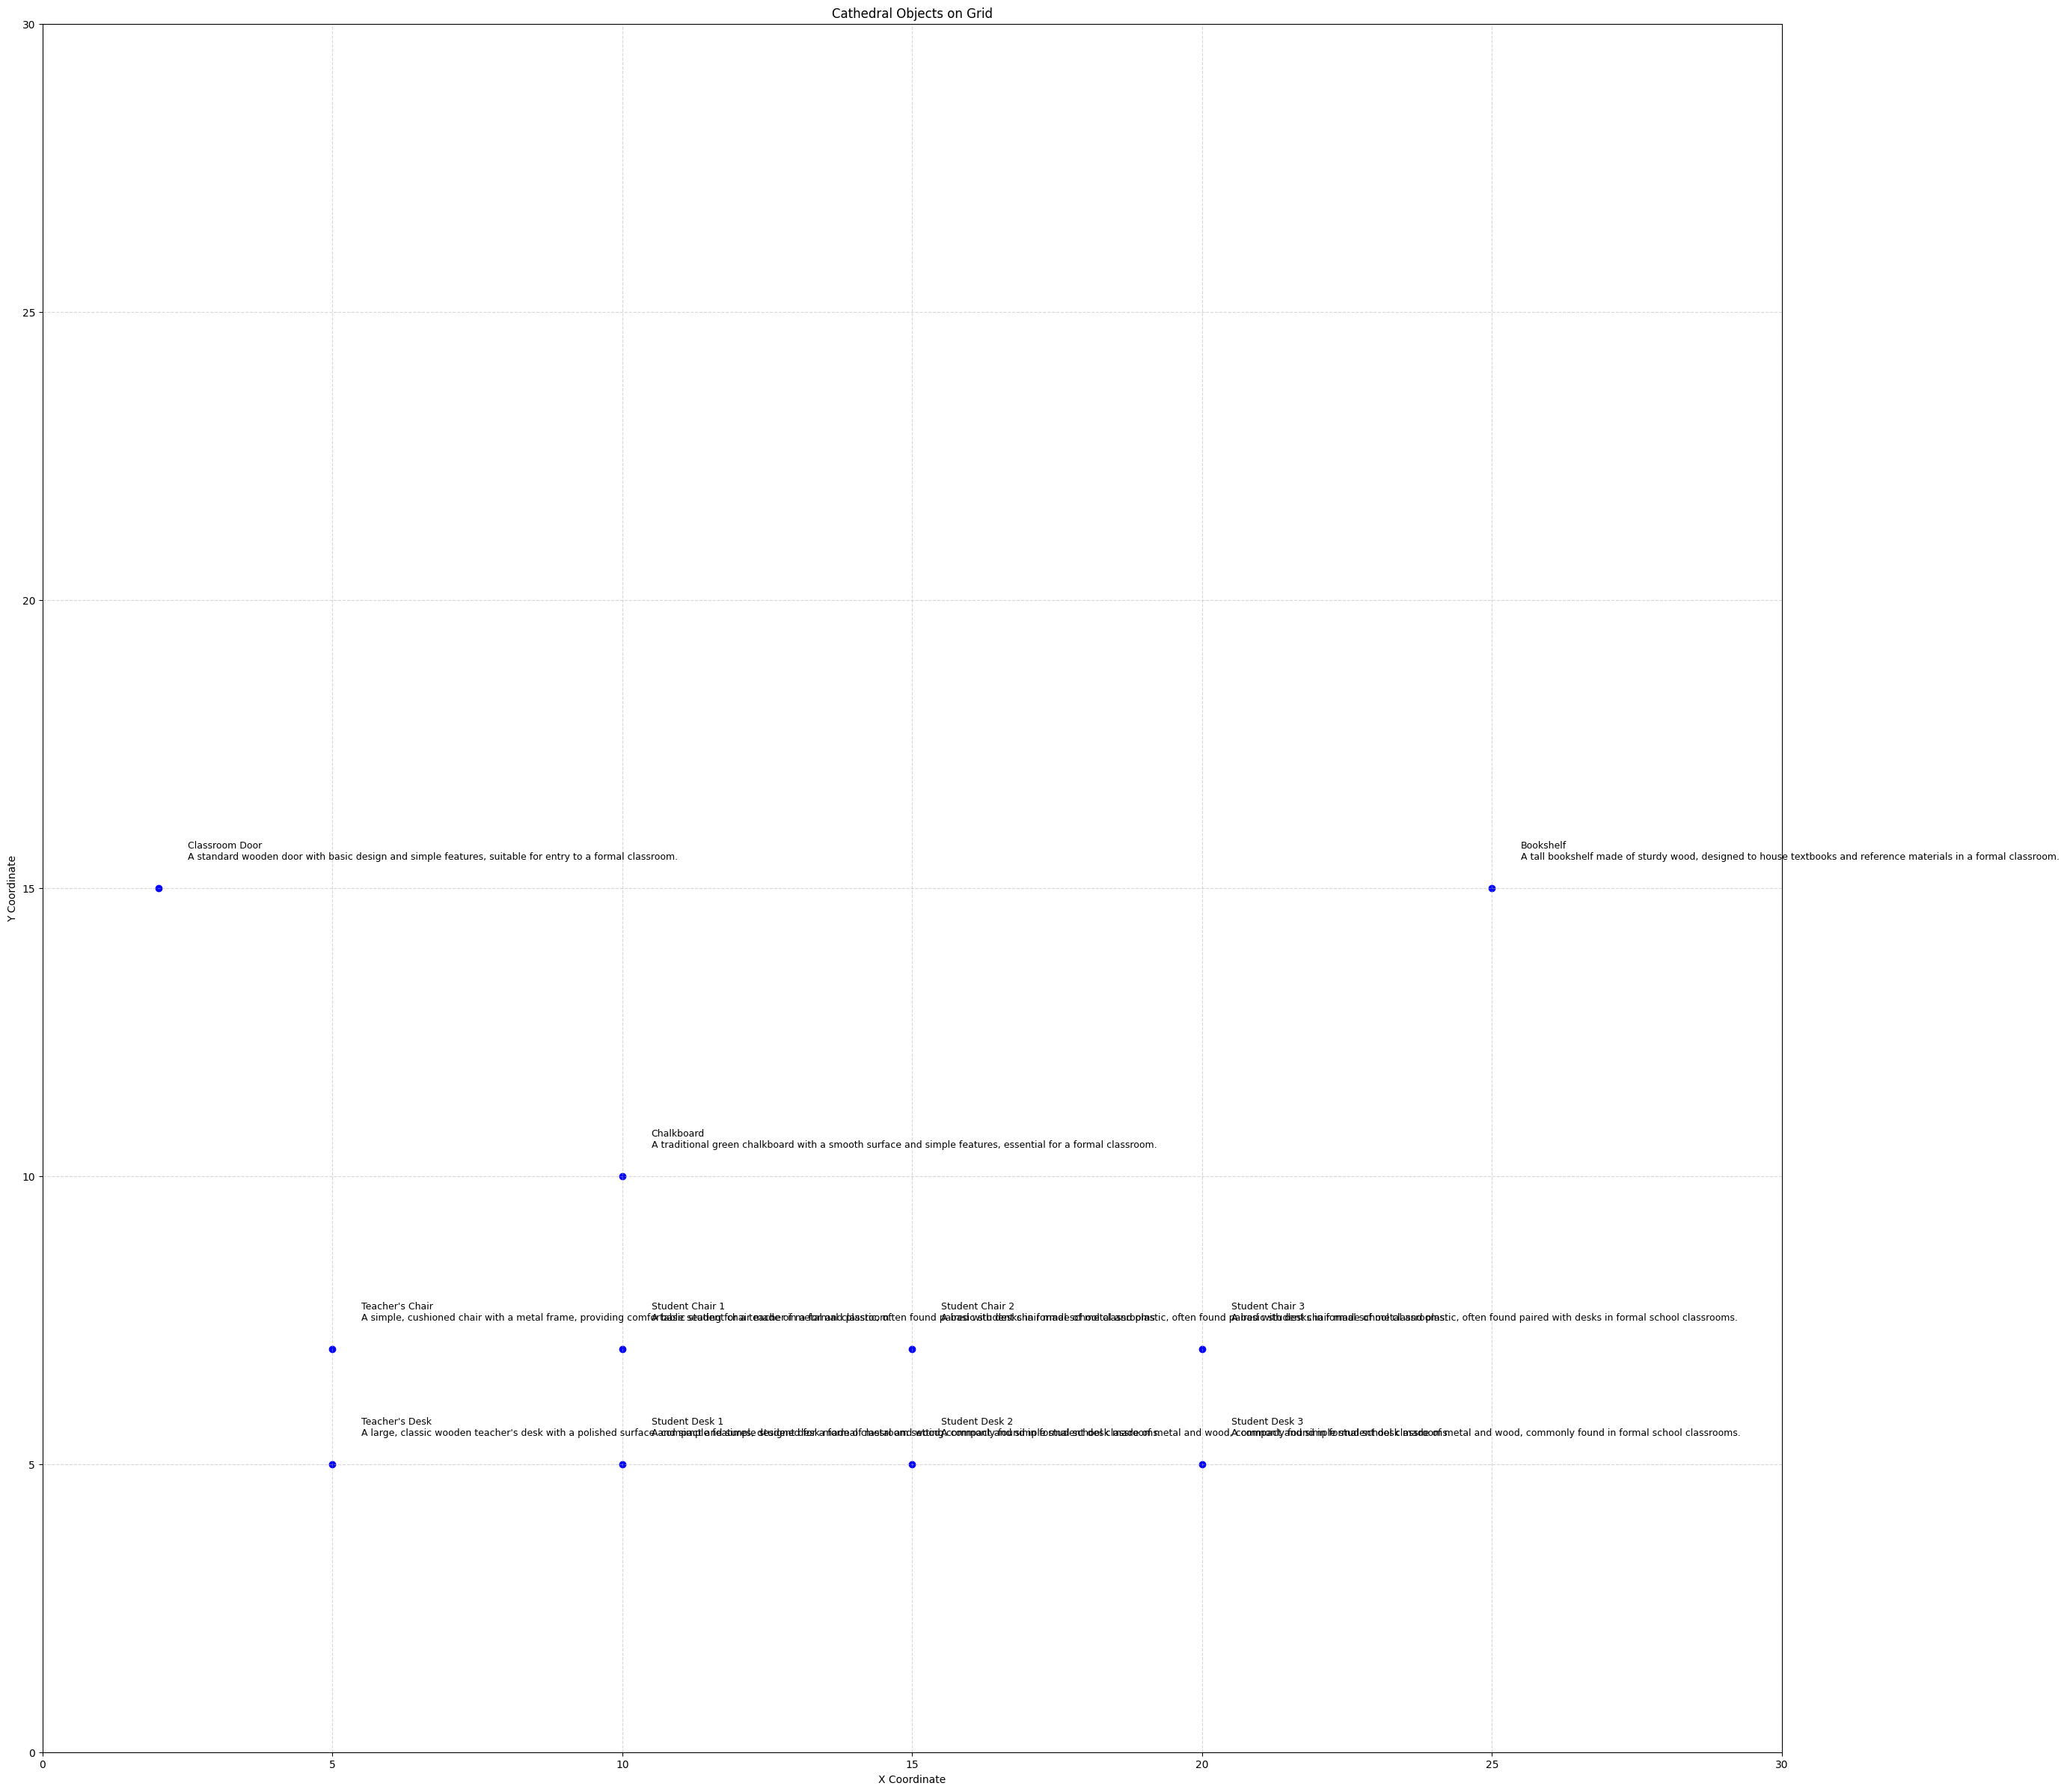

In [1]:
import hongdyu_gpt

In [3]:
from collections import OrderedDict
import re
print(hongdyu_gpt.object_names)
print(hongdyu_gpt.object_descriptions)
def normalize_name(name):
    return re.sub(r'\d+$', '', name)  # 이름 끝의 숫자 제거

# 일반화된 이름에 대한 설명 하나만 남기기
name_description_map = OrderedDict()
for name, description in zip(hongdyu_gpt.object_names, hongdyu_gpt.object_descriptions):
    norm_name = normalize_name(name)
    if norm_name not in name_description_map:
        name_description_map[norm_name] = description  # 첫 등장한 설명만 유지

# 결과 추출
normalized_names = list(name_description_map.keys())
normalized_descriptions = list(name_description_map.values())

print(normalized_names)
print(normalized_descriptions)


["Teacher's Desk", 'Student Desk 1', 'Student Desk 2', 'Student Desk 3', 'Classroom Door', 'Chalkboard', 'Bookshelf', "Teacher's Chair", 'Student Chair 1', 'Student Chair 2', 'Student Chair 3']
["A large, classic wooden teacher's desk with a polished surface and simple features, designed for a formal classroom setting.", 'A compact and simple student desk made of metal and wood, commonly found in formal school classrooms.', 'A compact and simple student desk made of metal and wood, commonly found in formal school classrooms.', 'A compact and simple student desk made of metal and wood, commonly found in formal school classrooms.', 'A standard wooden door with basic design and simple features, suitable for entry to a formal classroom.', 'A traditional green chalkboard with a smooth surface and simple features, essential for a formal classroom.', 'A tall bookshelf made of sturdy wood, designed to house textbooks and reference materials in a formal classroom.', 'A simple, cushioned chair w

In [11]:
for i in range(len(normalized_descriptions)):
    name = normalized_names[i]  # 파일 이름용 (중복 없는 이름)
    prompt = normalized_descriptions[i]  # 텍스트 프롬프트로 사용

    print(f"Generating for: {name}")

    batch_size = 1
    guidance_scale = 15.0

    latents = sample_latents(
        batch_size=batch_size,
        model=shap_e_model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=[prompt] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )

    for ii, latent in enumerate(latents):
        t = decode_latent_mesh(xm, latents).tri_mesh()
        with open(f'obj/{name}.obj', 'w') as f:
            t.write_obj(f)

    render_mode = 'nerf'  # or 'stf'
    size = 64  # render resolution

    cameras = create_pan_cameras(size, device)
    for iii, latent in enumerate(latents):
        images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
        display(gif_widget(images))


Generating for: Teacher's Desk


  0%|          | 0/64 [00:00<?, ?it/s]

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAJR6XY9rR5FpRI1jPJVgNJRgNpRgNZNgN5NgNpFgNpFgNZBgNp…

Generating for: Student Desk 


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAKiwuaiutaits6Sss6mrsaartaSqtKKqsKSptKOotKOosqKnsa…

Generating for: Classroom Door


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAJB+b4tmRIVbOIRWLoxVLotVLopVMYZVLoVVLoRVL4RVLoNVL4…

Generating for: Chalkboard


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAHbOaHbNaHbNZ3XNaHXNZ3TNZ3bMaHbMZ3bMZnXMaHXMZ3XMZn…

Generating for: Bookshelf


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAL2UbL2SarySa7mTbryRaruRa7yRabqRa7mRbLmRa7mRabiSb7…

Generating for: Teacher's Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAALa0tbWztLOztLSytbSytLOxtLGxsrCwsq+vsq+utK2vsa2tsK…

Generating for: Student Chair 


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAIey1oay2IWx14Sw1ISv04Gu1IKs0IGsz4Cs0H2szoKrz4Grz3…

In [12]:
import os

def parse_obj(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    vertices = []
    faces = []
    for line in lines:
        if line.startswith('v '):
            vertices.append(line.strip())
        elif line.startswith('f '):
            faces.append(line.strip())
    return vertices, faces

def translate_vertices(vertices, x_offset, y_offset):
    translated = []
    for v in vertices:
        parts = v.split()
        x, y, z = map(float, parts[1:4])
        x += x_offset
        y += y_offset
        translated.append(f"v {x:.6f} {y:.6f} {z:.6f}")
    return translated

def shift_face_indices(faces, offset):
    shifted = []
    for face in faces:
        parts = face.split()
        new_indices = []
        for p in parts[1:]:
            idx_parts = p.split('/')
            idx_parts[0] = str(int(idx_parts[0]) + offset)
            new_indices.append('/'.join(idx_parts))
        shifted.append('f ' + ' '.join(new_indices))
    return shifted

def merge_objs(base_path, object_names, x_coords, y_coords, output_path="merged.obj"):
    all_vertices = []
    all_faces = []
    vertex_offset = 0

    for i, obj_name in enumerate(object_names):
        norm_name = normalize_name(obj_name)
        obj_path = os.path.join(base_path, f"{norm_name}.obj")
        if not os.path.isfile(obj_path):
            print(f"❌ Missing OBJ file: {obj_path}")
            continue

        vertices, faces = parse_obj(obj_path)
        translated = translate_vertices(vertices, x_coords[i], y_coords[i])
        shifted_faces = shift_face_indices(faces, vertex_offset)

        all_vertices.extend(translated)
        all_faces.extend(shifted_faces)
        vertex_offset += len(vertices)

    with open(output_path, 'w') as f:
        f.write('\n'.join(all_vertices + all_faces))
    print(f"✅ Merged .obj written to: {output_path}")


In [13]:
merge_objs(
    base_path='/root/hongdyu/hongdyu/obj',
    object_names=hongdyu_gpt.object_names,
    x_coords=hongdyu_gpt.x_coords,
    y_coords=hongdyu_gpt.y_coords,
    output_path='/root/hongdyu/hongdyu/output.obj'
)

✅ Merged .obj written to: /root/hongdyu/hongdyu/output.obj
